In [ ]:
!pip install -qU datasets sentence-transformers
!pip install -q faiss-cpu

# Подготовка данных для обучения retrieval-модели
Для эффективного обучения модели поиска разделяем исходный датасет на тренировочную и тестовую выборки.

В качестве retrieval-модели была выбрана модель E5 от Hugging Face.

Особенностью модели является то, что требуется специальный формат входных данных: каждый пример должен быть представлен как пара `query` (вопрос) и `passage` (релевантный текстовый фрагмент). Такой формат позволяет модели научиться сопоставлять пользовательские запросы с соответствующими разделами документа.

In [3]:
import random
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('/content/qa_dataset.csv', encoding='utf-8-sig')

entries = []

for index, row in df.iterrows():
    query = row["Позитивный вопрос"]
    positive = row["Абзац"]

    entrie = {
        "query": query,
        "positive": positive,
    }
    entries.append(entrie)

Вывод первых 3 записей из словаря `entries`

In [5]:
for entrie in entries[:3]:
    print(f"""query: {entrie['query']}\npositive: {entrie['positive'][:100]}...
=========================================================================\n\n""")


query: Кто авторы текста гимна НГТУ им. Алексеева?
positive: Гимн НГТУ им. Р.Е. Алексеева

Слова Владимира Дубинского, Юрия Адясова, Владимира Карпея Музыка Нико...


query: Кто написал музыку к гимну НГТУ?
positive: Гимн НГТУ им. Р.Е. Алексеева

Слова Владимира Дубинского, Юрия Адясова, Владимира Карпея Музыка Нико...


query: Какой вуз упоминается в гимне как старейший среди вузов?
positive: Гимн НГТУ им. Р.Е. Алексеева

Слова Владимира Дубинского, Юрия Адясова, Владимира Карпея Музыка Нико...




Перемешиваем полученные записи и делим их на тренировочную и валидационную выборку в соотношении 80/20

In [6]:
random.shuffle(entries)

# Делим на выборки
split_idx = int(0.8 * len(entries))

train_data = entries[:split_idx]
val_data = entries[split_idx:]

print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}")

Train size: 753, Validation size: 189


In [ ]:
# Преобразуем в DataFrame и сохраняем
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

train_df.to_csv('train_data.csv', index=False, encoding='utf-8')
val_df.to_csv('val_data.csv', index=False, encoding='utf-8')

# Скачиваем
from google.colab import files
files.download('train_data.csv')
files.download('val_data.csv')

In [7]:
import os
os.environ['WANDB_DISABLED'] = 'true'

In [8]:
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformerTrainer, SentenceTransformerTrainingArguments
from sentence_transformers.evaluation import InformationRetrievalEvaluator
from datasets import Dataset
import torch

## Подготовка датасета в формате Hugging Face

Функция `prepare_dataset` преобразует данные в формат, необходимый для обучения модели E5:

Добавляются префиксы `"query: "` и `"passage: "` к текстам и создается словарь с двумя ключевыми полями: `anchor` - вопросы для поиска и `positive` - релевантные текстовые фрагменты

### Структура выходных данных:
```python
{
    "anchor": ["query: Кто авторы текста гимна НГТУ им. Алексеева?", "query: Кто написал музыку к гимну НГТУ?", ...],
    "positive": ["passage: Гимн НГТУ им. Р.Е. Алексеева...", "passage: Гимн НГТУ им. Р.Е. Алексеева...", ...]
}

In [9]:
def prepare_dataset(data):
    queries = []
    positives = []

    for item in data:
        queries.append(f"query: {item['query']}")
        positives.append(f"passage: {item['positive']}")

    return Dataset.from_dict({
        "anchor": queries,
        "positive": positives,
    })

train_dataset = prepare_dataset(train_data)
val_dataset = prepare_dataset(val_data)

##Инициализация модели и создание оценщика

In [ ]:
# 3. Инициализация модели
model = SentenceTransformer("intfloat/e5-base")

train_loss = losses.MultipleNegativesRankingLoss(model)

# 5. Подготовка Evaluator
def create_evaluator(dataset, train_data_1, test_data_1):
    import pandas as pd
    train_df = pd.DataFrame(train_data_1)
    test_df  = pd.DataFrame(test_data_1)

    # здесь вся выборка целиком
    whole_context = list(train_df.positive) + list(test_df.positive)

    corpus = {i: cont for i, cont in enumerate(whole_context)}

    test_df['idx'] = range(len(test_df))
    test_df = test_df.set_index('idx')

    queries = {}
    relevant_docs = {}

    for index, row in test_df.iterrows():
        q = row['query']
        queries[index] = q

        corrent_context_index = whole_context.index(row['positive'])
        relevant_docs[index] = [corrent_context_index]

    print('queries', queries)

    print('corpus', corpus)
    print('relevant_docs', relevant_docs)

    return InformationRetrievalEvaluator(
        queries=queries,
        corpus=corpus,
        relevant_docs=relevant_docs,
        show_progress_bar=True,
        accuracy_at_k=[3, 5]
    )

evaluator = create_evaluator(val_dataset, train_data, val_data)


Для построения графиков loss и accuracy будем сохранять метрики с помощью логгера

In [11]:
from transformers import TrainerCallback

class MetricsLogger:
    def __init__(self):
        self.logs = []

    def log(self, metrics):
        self.logs.append(metrics)

    def save(self, path):
        pd.DataFrame(self.logs).to_csv(path, index=False)

class CustomLoggingCallback(TrainerCallback):
    def __init__(self, metrics_logger):
        self.metrics_logger = metrics_logger

    def on_evaluate(self, args, state, control, **kwargs):
        if state.log_history:
            self.metrics_logger.log(state.log_history[-1])

# Инициализация
metrics_logger = MetricsLogger()
callback = CustomLoggingCallback(metrics_logger)


##Настройка и запуск обучения

In [ ]:
# 6. Настройка аргументов обучения
training_args = SentenceTransformerTrainingArguments(
    output_dir="./e5-retriever",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    warmup_steps=100,
    learning_rate=4e-5,
    fp16=True,
    eval_strategy="steps",
    eval_steps=2,
    save_steps=2,
    save_total_limit=3,
    load_best_model_at_end=True,
)

# 7. Инициализация Trainer
trainer = SentenceTransformerTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    loss=train_loss,
    evaluator=evaluator,
)

In [ ]:
trainer.add_callback(callback)
trainer.train()
metrics_logger.save("./training_metrics.csv")

## Создание графиков метрик обучения

График функции потерь Loss - отображает уменьшение ошибки модели в процессе обучения

График Accuracy@k - показывает долю релевантных документов, находящихся среди k ближайших соседей

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt

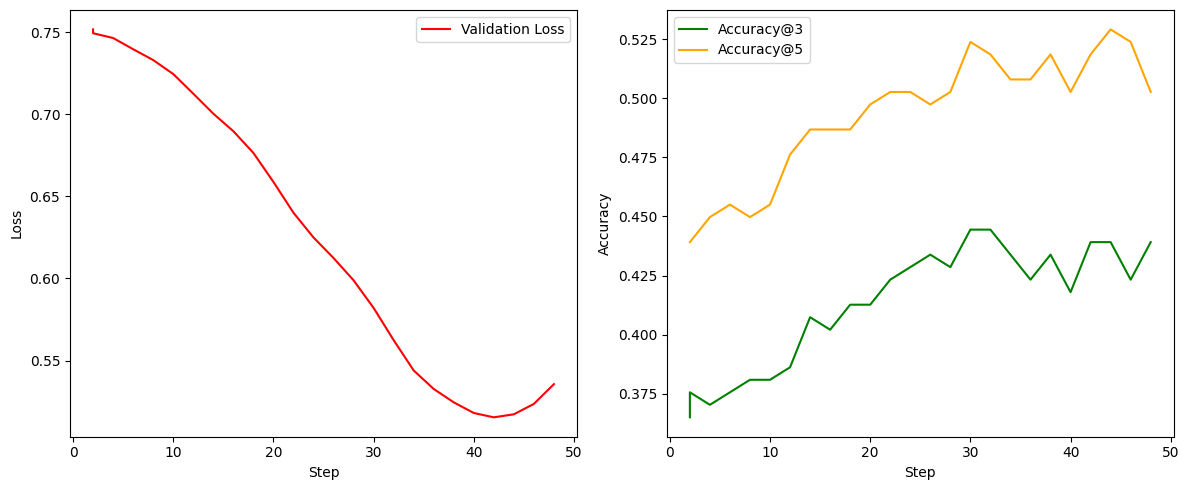

In [ ]:
def plot_metrics(logs_path):
    df = pd.read_csv(logs_path)

    # Фильтрация записей с валидационными метриками
    val_metrics = df[df["eval_loss"].notna()]

    plt.figure(figsize=(12, 5))

    # График Loss
    plt.subplot(1, 2, 1)
    plt.plot(val_metrics["step"], val_metrics["eval_loss"], label="Validation Loss", color="red")
    if "loss" in df.columns:
        plt.plot(df["step"], df["loss"], label="Training Loss", color="blue")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.legend()

    # График Accuracy@K
    plt.subplot(1, 2, 2)
    if "eval_cosine_accuracy@3" in val_metrics.columns:
        plt.plot(val_metrics["step"], val_metrics["eval_cosine_accuracy@3"], label="Accuracy@3", color="green")
    if "eval_cosine_accuracy@5" in val_metrics.columns:
        plt.plot(val_metrics["step"], val_metrics["eval_cosine_accuracy@5"], label="Accuracy@5", color="orange")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.savefig("./training_metrics.png")  # Сохраняем график
    plt.show()

plot_metrics("./training_metrics.csv")

In [ ]:
model.save()

In [ ]:
results = evaluator(model)
print(evaluator.primary_metric)
print(results[evaluator.primary_metric])


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/30 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it]

cosine_ndcg@10
0.5898270169093925


Скачиваем модель

In [ ]:
!zip -r /content/e5-custom-trained.zip /content/e5-custom-trained

In [ ]:
from google.colab import files
files.download('/content/e5-custom-trained.zip')